# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

from tqdm import tqdm
from fbprophet import Prophet

import lightgbm as lgb

In [162]:
import holidays

In [163]:
for date in holidays.UnitedStates(years=2019).items():
    print(date)

(datetime.date(2019, 1, 1), "New Year's Day")
(datetime.date(2019, 1, 21), 'Martin Luther King, Jr. Day')
(datetime.date(2019, 2, 18), "Washington's Birthday")
(datetime.date(2019, 5, 27), 'Memorial Day')
(datetime.date(2019, 7, 4), 'Independence Day')
(datetime.date(2019, 9, 2), 'Labor Day')
(datetime.date(2019, 10, 14), 'Columbus Day')
(datetime.date(2019, 11, 11), 'Veterans Day')
(datetime.date(2019, 11, 28), 'Thanksgiving')
(datetime.date(2019, 12, 25), 'Christmas Day')


In [164]:
for date in holidays.UnitedStates(years=2018).items():
    print(date)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 1, 15), 'Martin Luther King, Jr. Day')
(datetime.date(2018, 2, 19), "Washington's Birthday")
(datetime.date(2018, 5, 28), 'Memorial Day')
(datetime.date(2018, 7, 4), 'Independence Day')
(datetime.date(2018, 9, 3), 'Labor Day')
(datetime.date(2018, 10, 8), 'Columbus Day')
(datetime.date(2018, 11, 11), 'Veterans Day')
(datetime.date(2018, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2018, 11, 22), 'Thanksgiving')
(datetime.date(2018, 12, 25), 'Christmas Day')


In [166]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro Bronx',
        'Triboro Manhattan',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [3]:
df = return_series('mta.csv')

In [175]:
_df = df.unstack().T

In [176]:
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [177]:
_df = _df.reset_index()
_df

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
0,2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286
1,2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2,2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
3,2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
4,2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...,...
981,2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270
982,2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513
983,2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546
984,2020-09-11,56878,24493,70659,24483,73386,111209,139712,39046,107214,131970


In [178]:
_df.columns

Index(['datetime', 'Brooklyn Battery', 'Cross Bay', 'Henry Hudson',
       'Marine Parkway', 'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
       'Triboro Manhattan', 'Verrazano', 'Whitestone'],
      dtype='object', name='plaza_id')

In [179]:
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
                                                        'Triboro Manhattan', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)
_df_melt

,plaza_id,value
datetime,,
2018-01-01,Brooklyn Battery,29163
2018-01-02,Brooklyn Battery,47160
2018-01-03,Brooklyn Battery,54005
2018-01-04,Brooklyn Battery,20484
2018-01-05,Brooklyn Battery,38007
...,...,...
2020-09-08,Whitestone,121270
2020-09-09,Whitestone,118513
2020-09-10,Whitestone,114546


In [180]:

def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, 5)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    
    return _df

In [181]:
_df_melt = date_features(_df_melt)
_df_melt.reset_index(inplace=True)

In [183]:
conditions = [
    _df_melt['plaza_id'].eq('Triboro Bronx'),
    _df_melt['plaza_id'].eq('Triboro Manhattan'),
    _df_melt['plaza_id'].eq('Whitestone'),
    _df_melt['plaza_id'].eq('Henry Hudson'),
    _df_melt['plaza_id'].eq('Marine Parkway'),
    _df_melt['plaza_id'].eq('Cross Bay'),
    _df_melt['plaza_id'].eq('Queens Midtown'),
    _df_melt['plaza_id'].eq('Brooklyn Battery'),
    _df_melt['plaza_id'].eq('Throgs Neck'),
    _df_melt['plaza_id'].eq('Verrazano')
    
]
choices = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]

_df_melt['plaza_id'] = np.select(conditions, choices, 0)
_df_melt

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,121270,9,1,2020,37,8,3,4,0,0
9856,2020-09-09,3,118513,9,2,2020,37,9,3,4,0,0
9857,2020-09-10,3,114546,9,3,2020,37,10,3,4,0,0
9858,2020-09-11,3,131970,9,4,2020,37,11,3,4,0,0


In [184]:
train_set = _df_melt.loc[_df_melt['datetime'] <= '2020-08-22'].copy()
test_set = _df_melt.loc[_df_melt['datetime'] > '2020-08-22'].copy()
# test_set

In [185]:
# train_set

In [186]:
train_set['lag_7'] = train_set[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
train_set['lag_28'] = train_set[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,0,123273.0,114042.0
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,0,116497.0,112825.0
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,0,122549.0,115346.0
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,0,141229.0,127859.0


In [187]:
train_set['mean_lag7_roll7'] = train_set[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(7).mean())
train_set['mean_lag7_roll28'] = train_set[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(28).mean())
train_set['mean_lag28_roll7'] = train_set[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(7).mean())
train_set['mean_lag28_roll28'] = train_set[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(28).mean())
train_set['week'] = train_set['week'].astype('int64')
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [190]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'year', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value']
train_cols = train_set.columns[~train_set.columns.isin(useless_cols)]
X_train = train_set[train_cols]
y_train = train_set['value']

In [191]:

train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
fake_valid_inds = np.random.choice(len(X_train), 2000)
fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=categorical_features,
                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [192]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
#     'num_iterations' : 200,
    'num_iterations' : 2500,
}

In [193]:
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 6118.31
[200]	valid_0's rmse: 4204.38
[300]	valid_0's rmse: 3611.12
[400]	valid_0's rmse: 3135.33
[500]	valid_0's rmse: 2811.72
[600]	valid_0's rmse: 2576.43
[700]	valid_0's rmse: 2403.88
[800]	valid_0's rmse: 2213.58
[900]	valid_0's rmse: 2055.41
[1000]	valid_0's rmse: 1933.18
[1100]	valid_0's rmse: 1828.11
[1200]	valid_0's rmse: 1720.32
[1300]	valid_0's rmse: 1615.39
[1400]	valid_0's rmse: 1531.55
[1500]	valid_0's rmse: 1450.85
[1600]	valid_0's rmse: 1370.59
[1700]	valid_0's rmse: 1295.23
[1800]	valid_0's rmse: 1232.13
[1900]	valid_0's rmse: 1174.44
[2000]	valid_0's rmse: 1112.8
[2100]	valid_0's rmse: 1065.19
[2200]	valid_0's rmse: 1017.29
[2300]	valid_0's rmse: 976.493
[2400]	valid_0's rmse: 932.544
[2500]	valid_0's rmse: 896.004


In [194]:
first_iter = test_set.loc[test_set['datetime'] <= '2020-08-29'].copy()
first_iter['value'] = np.nan
first_iter

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
965,2020-08-23,8,NaN,8,6,2020,34,23,3,4,1,0
966,2020-08-24,8,NaN,8,0,2020,35,24,3,4,0,0
967,2020-08-25,8,NaN,8,1,2020,35,25,3,4,0,0
968,2020-08-26,8,NaN,8,2,2020,35,26,3,4,0,0
969,2020-08-27,8,NaN,8,3,2020,35,27,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,0
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,0
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,0
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,0


In [195]:
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [196]:
_first_concat = pd.concat([train_set, first_iter])
# _first_concat

In [197]:
_first_concat['lag_7'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
_first_concat['lag_28'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)

In [198]:
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,NaN,NaN,NaN,NaN
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,NaN,NaN,NaN,NaN
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,NaN,NaN,NaN,NaN
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,NaN,NaN,NaN,NaN


In [199]:
_first_concat['lag_28'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,NaN,NaN,NaN,NaN
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,NaN,NaN,NaN,NaN
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,NaN,NaN,NaN,NaN
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,NaN,NaN,NaN,NaN


In [200]:
_first_concat['mean_lag7_roll7'] = _first_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
_first_concat['mean_lag7_roll28'] = _first_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
_first_concat['mean_lag28_roll7'] = _first_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
_first_concat['mean_lag28_roll28'] = _first_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
_first_concat['week'] = _first_concat['week'].astype('int64')
# _first_concat

In [201]:
# _first_concat

In [202]:
_first_concat_feats = _first_concat[train_cols].copy()
_first_concat_feats

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,3,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000
9842,3,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429
9843,3,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857
9844,3,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714


In [203]:
first_pred = m_lgb.predict(_first_concat_feats)

In [204]:
_first_concat.iloc[-70:]['value'] = first_pred[-70:].copy()
_first_concat

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,121552.785611,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000
9842,2020-08-26,3,123211.788921,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429
9843,2020-08-27,3,135157.508786,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857
9844,2020-08-28,3,140932.456005,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714


In [205]:
second_iter = test_set.loc[(test_set['datetime'] <= (pd.to_datetime('2020-08-29') + datetime.timedelta(days=7))) & (test_set['datetime'] > '2020-08-29')].copy()
second_iter['value'] = np.nan
second_iter

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
972,2020-08-30,8,NaN,8,6,2020,35,30,3,4,1,0
973,2020-08-31,8,NaN,8,0,2020,36,31,3,4,0,0
974,2020-09-01,8,NaN,9,1,2020,36,1,3,4,0,0
975,2020-09-02,8,NaN,9,2,2020,36,2,3,4,0,0
976,2020-09-03,8,NaN,9,3,2020,36,3,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9848,2020-09-01,3,NaN,9,1,2020,36,1,3,4,0,0
9849,2020-09-02,3,NaN,9,2,2020,36,2,3,4,0,0
9850,2020-09-03,3,NaN,9,3,2020,36,3,3,4,0,0
9851,2020-09-04,3,NaN,9,4,2020,36,4,3,4,0,0


In [206]:
_second_concat = pd.concat([_first_concat, second_iter])
_second_concat['lag_7'] = _second_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
_second_concat['lag_28'] = _second_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
_second_concat['mean_lag7_roll7'] = _second_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
_second_concat['mean_lag7_roll28'] = _second_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
_second_concat['mean_lag28_roll7'] = _second_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
_second_concat['mean_lag28_roll28'] = _second_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
_second_concat['week'] = _second_concat['week'].astype('int64')


_second_concat_feats = _second_concat[train_cols]
_second_concat_feats

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9848,3,9,1,2020,36,1,3,4,0,0,121552.785611,89355.0,128070.553492,124135.066945,118728.285714,115338.821429
9849,3,9,2,2020,36,2,3,4,0,0,123211.788921,124796.0,128208.237624,124202.737977,119225.285714,116021.642857
9850,3,9,3,2020,36,3,3,4,0,0,135157.508786,126998.0,128004.881736,124621.363291,119734.142857,116457.142857
9851,3,9,4,2020,36,4,3,4,0,0,140932.456005,128166.0,127272.089737,124739.022434,118381.000000,117272.178571


In [207]:
second_pred = m_lgb.predict(_second_concat_feats)

In [208]:
_second_concat.iloc[-70:]['value'] = second_pred[-70:]
_second_concat

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9848,2020-09-01,3,118404.387121,9,1,2020,36,1,3,4,0,0,121552.785611,89355.0,128070.553492,124135.066945,118728.285714,115338.821429
9849,2020-09-02,3,118226.937788,9,2,2020,36,2,3,4,0,0,123211.788921,124796.0,128208.237624,124202.737977,119225.285714,116021.642857
9850,2020-09-03,3,125345.324308,9,3,2020,36,3,3,4,0,0,135157.508786,126998.0,128004.881736,124621.363291,119734.142857,116457.142857
9851,2020-09-04,3,138327.206381,9,4,2020,36,4,3,4,0,0,140932.456005,128166.0,127272.089737,124739.022434,118381.000000,117272.178571


In [209]:
third_iter = test_set.loc[(test_set['datetime'] <= (pd.to_datetime('2020-09-05') + datetime.timedelta(days=7))) & (test_set['datetime'] > '2020-09-05')].copy()
third_iter['value'] = np.nan
third_iter

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
979,2020-09-06,8,NaN,9,6,2020,36,6,3,4,1,0
980,2020-09-07,8,NaN,9,0,2020,37,7,3,4,0,1
981,2020-09-08,8,NaN,9,1,2020,37,8,3,4,0,0
982,2020-09-09,8,NaN,9,2,2020,37,9,3,4,0,0
983,2020-09-10,8,NaN,9,3,2020,37,10,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,NaN,9,1,2020,37,8,3,4,0,0
9856,2020-09-09,3,NaN,9,2,2020,37,9,3,4,0,0
9857,2020-09-10,3,NaN,9,3,2020,37,10,3,4,0,0
9858,2020-09-11,3,NaN,9,4,2020,37,11,3,4,0,0


In [210]:
_third_concat = pd.concat([_second_concat, third_iter])
_third_concat['lag_7'] = _third_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
_third_concat['lag_28'] = _third_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
_third_concat['mean_lag7_roll7'] = _third_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
_third_concat['mean_lag7_roll28'] = _third_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
_third_concat['mean_lag28_roll7'] = _third_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
_third_concat['mean_lag28_roll28'] = _third_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
_third_concat['week'] = _third_concat['week'].astype('int64')


_third_concat_feats = _third_concat[train_cols]
_third_concat_feats

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9855,3,9,1,2020,37,8,3,4,0,0,118404.387121,123273.0,127814.849755,126406.707955,126017.571429,119920.464286
9856,3,9,2,2020,37,9,3,4,0,0,118226.937788,116497.0,127102.728164,126172.098590,124832.000000,120017.928571
9857,3,9,3,2020,37,10,3,4,0,0,125345.324308,122549.0,125700.987525,126113.074458,124196.428571,120275.142857
9858,3,9,4,2020,37,11,3,4,0,0,138327.206381,141229.0,125328.809007,126475.974686,126062.571429,120858.142857


In [211]:
third_pred = m_lgb.predict(_third_concat_feats)

In [212]:
_third_concat.iloc[-70:]['value'] = third_pred[-70:]
_third_concat

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,118146.819982,9,1,2020,37,8,3,4,0,0,118404.387121,123273.0,127814.849755,126406.707955,126017.571429,119920.464286
9856,2020-09-09,3,120029.715920,9,2,2020,37,9,3,4,0,0,118226.937788,116497.0,127102.728164,126172.098590,124832.000000,120017.928571
9857,2020-09-10,3,123505.361416,9,3,2020,37,10,3,4,0,0,125345.324308,122549.0,125700.987525,126113.074458,124196.428571,120275.142857
9858,2020-09-11,3,129421.286130,9,4,2020,37,11,3,4,0,0,138327.206381,141229.0,125328.809007,126475.974686,126062.571429,120858.142857


In [213]:
np.sqrt(mean_squared_error(_third_concat.iloc[-210:]['value'], test_set['value']))

42105.46643987366

In [214]:
test_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
965,2020-08-23,8,33512,8,6,2020,34,23,3,4,1,0
966,2020-08-24,8,52900,8,0,2020,35,24,3,4,0,0
967,2020-08-25,8,53262,8,1,2020,35,25,3,4,0,0
968,2020-08-26,8,56023,8,2,2020,35,26,3,4,0,0
969,2020-08-27,8,56449,8,3,2020,35,27,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,121270,9,1,2020,37,8,3,4,0,0
9856,2020-09-09,3,118513,9,2,2020,37,9,3,4,0,0
9857,2020-09-10,3,114546,9,3,2020,37,10,3,4,0,0
9858,2020-09-11,3,131970,9,4,2020,37,11,3,4,0,0


In [215]:
_third_concat.iloc[-210:]['value'].values

array([ 31891.70294047,  51253.91251295,  52411.45032039,  51539.83376654,
        58119.7013131 ,  55733.89130577,  39938.3099676 ,  19276.5353393 ,
        25038.91935632,  24071.84799242,  25239.63069703,  26134.74169164,
        26352.37209758,  27196.49712561,  43493.66157629,  56284.45145003,
        55896.13526733,  58306.18453423,  65671.89020338,  67546.75155015,
        57459.82912888,  19356.44920205,  25742.34335312,  24167.53778671,
        25266.36026685,  25866.02772512,  25576.08312683,  27471.49405293,
        41938.67624203,  60903.79888658,  63325.49317555,  63100.16610686,
        71006.49186729,  71563.12103898,  53795.3321221 , 103488.4949112 ,
       104643.86746285, 105237.07263206, 107563.22924315, 113642.92090873,
       115779.43630869, 118903.65924798, 101673.01815867, 123502.86835322,
       124307.08352295, 125758.44252383, 135406.2383479 , 132222.78650697,
       122480.8497496 ,  24794.24832757,  35774.30083967,  34500.83593099,
        36208.83254047,  

In [216]:
test_set.loc[test_set['plaza_id'].eq(8)].index

Int64Index([965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
            978, 979, 980, 981, 982, 983, 984, 985],
           dtype='int64')

In [217]:
_third_concat.loc[_third_concat.index in [965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
            978, 979, 980, 981, 982, 983, 984, 985]]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [218]:
_actual_8 = test_set.loc[test_set['plaza_id'].eq(8)]

In [219]:
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(8)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']

In [220]:
_thirdwhat1

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
965,2020-08-23,8,31891.702940,8,6,2020,34,23,3,4,1,0,26879.000000,29490.0,46940.571429,45989.250000,44800.000000,42905.964286
966,2020-08-24,8,51253.912513,8,0,2020,35,24,3,4,0,0,51279.000000,50115.0,46819.285714,46092.285714,45045.857143,42902.821429
967,2020-08-25,8,52411.450320,8,1,2020,35,25,3,4,0,0,54168.000000,52367.0,47015.285714,46256.464286,45445.285714,42989.714286
968,2020-08-26,8,51539.833767,8,2,2020,35,26,3,4,0,0,52481.000000,52472.0,46905.857143,46228.428571,45331.857143,42990.178571
969,2020-08-27,8,58119.701313,8,3,2020,35,27,3,4,0,0,57221.000000,50005.0,47181.000000,46404.142857,45003.857143,42788.500000
970,2020-08-28,8,55733.891306,8,4,2020,35,28,3,4,0,0,53822.000000,52069.0,47149.285714,46646.714286,45723.714286,43579.142857
971,2020-08-29,8,39938.309968,8,5,2020,35,29,3,4,1,0,36817.000000,33966.0,47523.857143,46763.464286,45783.428571,44213.750000
972,2020-08-30,8,36089.773137,8,6,2020,35,30,3,4,1,0,31891.702940,28669.0,48239.957563,46849.239391,45666.142857,44373.428571
973,2020-08-31,8,52047.878802,8,0,2020,36,31,3,4,0,0,51253.912513,52776.0,48236.373636,46889.914838,46046.285714,44595.214286
974,2020-09-01,8,53162.088060,9,1,2020,36,1,3,4,0,0,52411.450320,39131.0,47985.437968,46891.502349,44155.428571,44275.535714


In [221]:
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_8['value']))

4316.048358640111

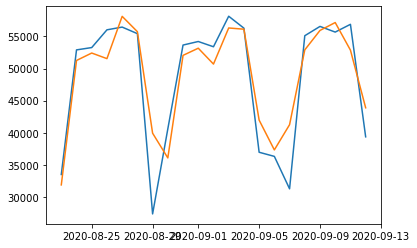

In [222]:
plt.plot(_actual_8['datetime'], _actual_8['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [128]:
_third_concat.iloc[965,:]

datetime             2018-01-01 00:00:00
plaza_id                               6
value                              13705
month                                  1
dayofweek                              0
year                                2018
week                                   1
day                                    1
quarter                                1
Phase                                  5
weekend                                0
lag_7                                NaN
lag_28                               NaN
mean_lag7_roll7                      NaN
mean_lag7_roll28                     NaN
mean_lag28_roll7                     NaN
mean_lag28_roll28                    NaN
Name: 986, dtype: object

In [129]:
_third_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,118720.771741,9,1,2020,37,8,3,4,0,121903.949337,123273.0,127793.466104,126420.159759,126017.571429,119920.464286
9856,2020-09-09,3,114293.766188,9,2,2020,37,9,3,4,0,110161.691065,116497.0,125980.667429,125897.505869,124832.000000,120017.928571
9857,2020-09-10,3,118430.147728,9,3,2020,37,10,3,4,0,120209.195680,122549.0,123628.624551,125655.048572,124196.428571,120275.142857
9858,2020-09-11,3,128684.001379,9,4,2020,37,11,3,4,0,138435.270801,141229.0,122928.598481,126021.808243,126062.571429,120858.142857


In [223]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(3)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(3)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

7703.047484670573

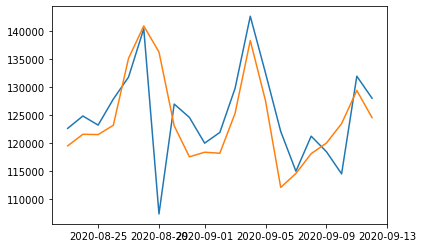

In [224]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [225]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(4)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(4)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

5049.275701765339

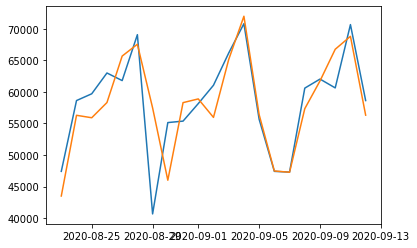

In [226]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [228]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(0)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(0)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4958.9555848052305

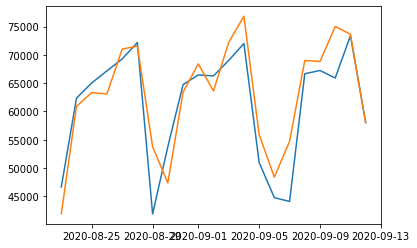

In [229]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

10    21
9     21
8     21
6     21
5     21
4     21
3     21
2     21
1     21
0     21
Name: plaza_id, dtype: int64

In [231]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(1)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(1)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

8363.999988487863

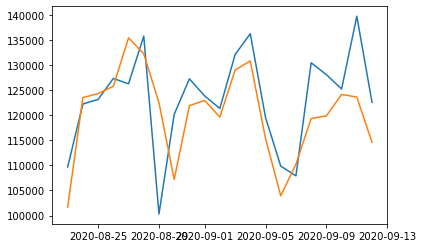

In [232]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [233]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(2)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(2)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4129.131575597295

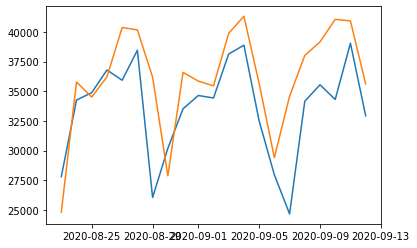

In [234]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [235]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(5)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(5)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4971.965397584133

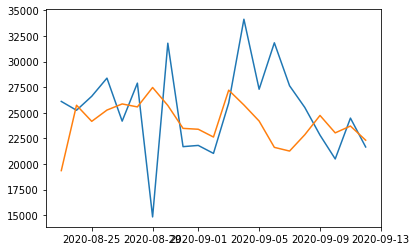

In [236]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [237]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(6)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(6)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

3333.7605647753003

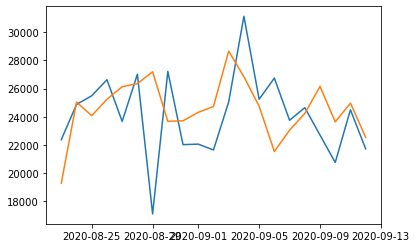

In [238]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [239]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(8)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(8)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4316.048358640111

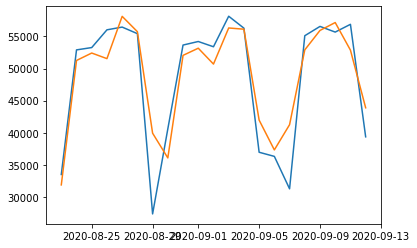

In [240]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [241]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(9)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(9)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

10097.641091412164

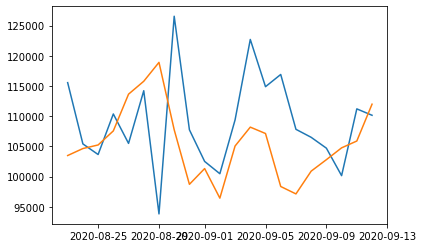

In [242]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [243]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(10)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(10)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

5269.72400189709

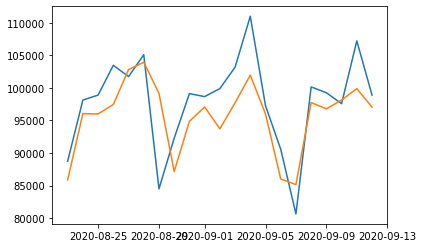

In [244]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])